In [1]:
import torch # need to import torch before numpy because of a mix in pip and conda install

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.approximation import *
from src.theory import *
from src.analysis import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
# check if mps works
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')


# Global parameters

In [3]:
# specify system parameters
params = {
    "N": 10000, # number of nodes
    "K": 100, # number of connections per node
    "mu": 0.2, # fraction of nodes that receive input
    "sigma": 0.01, # standard deviation of noise
    "epsilon": 0.1, # overap
    "window": 1, # window
    "seed": 1000, # seed
}

# reduce list of lambdas for testing purpose
list_lambda = 1 - 10 ** np.linspace(-1, -4, 4)

print(list_lambda)

[0.9    0.99   0.999  0.9999]


## Step-by-step analysis (cf. scripts/run_analysis_simulation.py)

In [4]:
database = "./simulations.db"

In [5]:
# load relevant information from database
import sqlite3
con = sqlite3.connect(database)
cur = con.cursor()

# load function approximation from database
beta_interpolation = pd.read_sql_query(
    f"SELECT * FROM beta_interpolations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}",
    con,
)
# check that there is a unique function approximation
if not len(beta_interpolation) == 1:
    raise ValueError(
        f"No unique function approximation in database for params (either 0 or multiple entries)"
    )
print(
    f"Load beta interpolation from file: {beta_interpolation['filename'].values[0]}"
)
beta_approx = FunctionApproximation(
    filename=beta_interpolation["filename"].values[0]
)
con.close()

Load beta interpolation from file: ./dat/beta_interpolation_N=10000_K=100_mu=0.2_seed=1000.pkl


### Check that approximation yields distributed result around theoretical mean

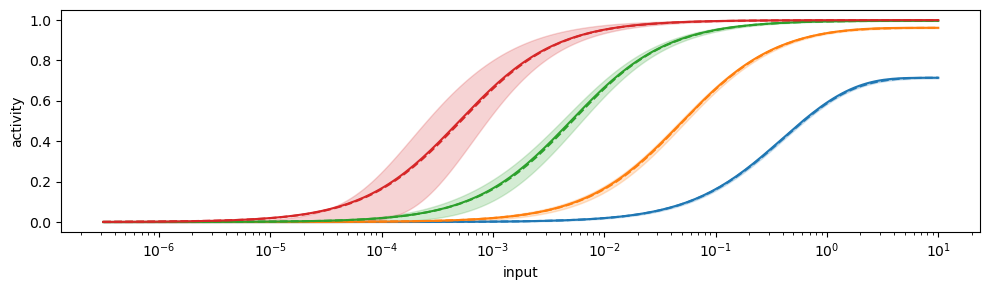

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 200)
for i, lam in enumerate(list_lambda):
    # theory
    ref = axes.plot(hs, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam))
    # simulation approximation with variance!
    avals, bvals = beta_approx(lam*np.ones_like(hs), params['window']*np.ones_like(hs), hs)
    mean = avals/(avals+bvals)
    # calculate percentiles from stats.beta(a,b)
    beta = stats.beta(avals, bvals)
    percentile_25 = beta.ppf(0.25)
    percentile_50 = beta.ppf(0.5)
    percentile_75 = beta.ppf(0.75)
    axes.plot(hs, mean, color=ref[0].get_color(), linestyle='--')
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
#axes.legend()
plt.tight_layout()
plt.show()

### Convolution of beta distribution with Guassian 

In [7]:
#check support
delta = 0.1
x_gauss = support_gauss(0.5, delta)
print(x_gauss)
x_conv = support_conv_pmf_gauss(np.arange(0,1+delta, delta), x_gauss)
print(x_conv) 

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8
  0.9  1.   1.1  1.2  1.3  1.4  1.5]


In [8]:
# parameters of the beta distribution
loc = beta_approx.params["loc"]
scale = beta_approx.params["scale"]
# support for the gaussian noise
delta = 1 / beta_approx.params["N"]
x_gauss = support_gauss(5 * params["sigma"], delta)
# pmf of the gaussian noise (needs delta for normalization)
pmf_gauss = stats.norm.pdf(x_gauss, 0, params["sigma"]) * delta 

# full support for convolution (add another delta to the right because beta distribution is calculated from the difference of the cdf)
x_beta = support_conv_pmf_gauss([0,1+delta], x_gauss)
x_noise = support_conv_pmf_gauss([0,1], x_gauss)

def pmf_noise(window, lam, h):
    a,b = beta_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf = np.diff(stats.beta.cdf(x_beta, a, b, loc=loc, scale=scale))
    return np.convolve(pmf, pmf_gauss, mode="same")


100%|██████████| 25/25 [00:00<00:00, 165.10it/s]


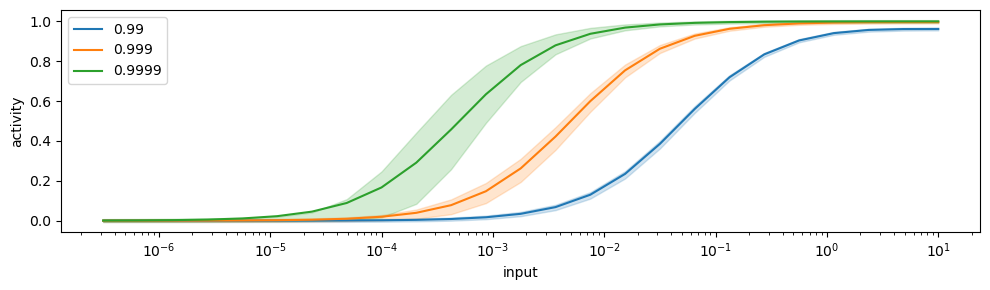

In [9]:
# replot previous plot with convolution
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 25)
for i, lam in enumerate(list_lambda[1:4]):
    # theory
    ref = axes.plot(hs, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam))
    percentile_25 = np.zeros_like(hs)
    percentile_50 = np.zeros_like(hs)
    percentile_75 = np.zeros_like(hs)
    for (i,h) in tqdm(enumerate(hs), total=len(hs)):
        pmf = pmf_noise(params['window'], lam, h)
        percentile_25[i] = x_noise[np.searchsorted(np.cumsum(pmf), 0.25)]
        percentile_50[i] = x_noise[np.searchsorted(np.cumsum(pmf), 0.5)]
        percentile_75[i] = x_noise[np.searchsorted(np.cumsum(pmf), 0.75)]
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
axes.legend()
plt.tight_layout()
plt.show()

In [10]:
h_range = beta_approx.input_range[beta_approx.input_names.index("h")]

# define function for dask
def analyse(lam, verbose=False):
    """
        return lambda, number of discriminable intervals, dynamic range
    """
    pmf_o_given_h = lambda h: pmf_noise(params['window'], lam, h)

    # get reference distributions from mean-field solution (needs delta for normalization because in domain [0,1] with stepsize delta)
    pmf_refs = [stats.norm.pdf(x_noise, mean_field_activity(lam, params['mu'], h), params['sigma'])*delta for h in [0, np.inf]]

    # get dynamic range and number of discriminable states
    dr, nd = analysis_dr_nd(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], verbose=verbose)
    
    return lam, dr, nd

In [11]:
analyse(0.9)

(0.9, 22.45090545138995, 21.0)

In [12]:
# parallize over lambdas with dask
from dask.distributed import Client, LocalCluster, as_completed
cluster = LocalCluster()
dask_client = Client(cluster)

futures = dask_client.map(analyse, list_lambda)

# run analysis
data = []
for future in tqdm(as_completed(futures), total=len(list_lambda)):
    data.append(future.result())

print(data)

# sort data by first column
data = np.array(sorted(data, key=lambda x: x[0]))

100%|██████████| 4/4 [00:20<00:00,  5.14s/it]

[(0.9999, 18.560777306528973, 2.0), (0.999, 26.346707035475525, 7.0), (0.99, 27.720474402811032, 17.0), (0.9, 22.45090545138995, 21.0)]


In [13]:
data

array([[ 0.9       , 22.45090545, 21.        ],
       [ 0.99      , 27.7204744 , 17.        ],
       [ 0.999     , 26.34670704,  7.        ],
       [ 0.9999    , 18.56077731,  2.        ]])

# Additional plots to check analysis

## Distribution of noisy probability mass functions from the approximation

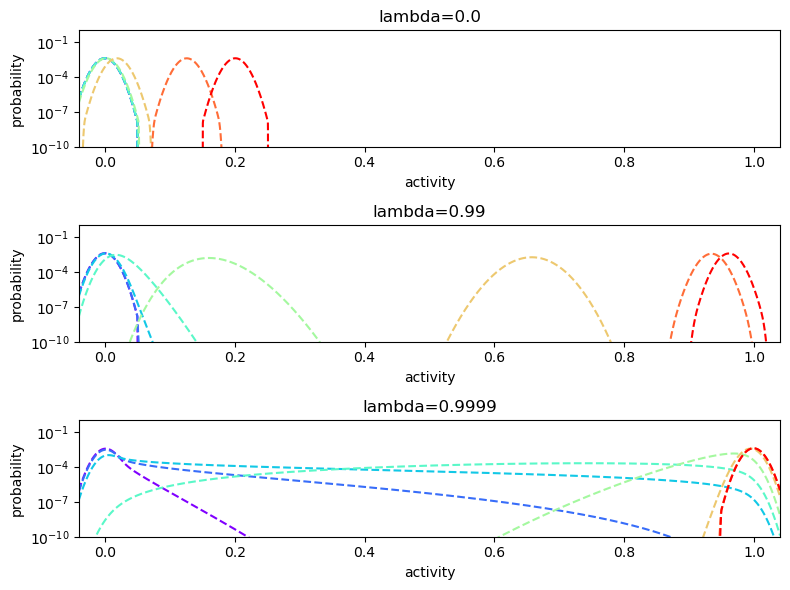

In [14]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.99, 0.9999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(8, 2*len(list_lam)))
window=1

list_hs = 10**np.linspace(-6, 1, 8)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        c = next(color)
        # from ML dashed
        pmf_ml = pmf_noise(window, lam, h)
        axes[i].plot(x_noise, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*params["sigma"],1+4*params["sigma"])
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()
